In [72]:
import numpy as np
from functools import partial
import pandas as pd
#import matplotlib as mpl
#mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
#import mpld3
#mpld3.enable_notebook()

import sys
sys.path.append('../python/')
import EdwRes

font = {'family' : 'sans-serif',
        'weight' : 'medium',
        'size'   : 22
       }

xtick = {'direction' : 'in',
         'top' : 'True',
         'major.size' : '8',
         'major.width' : '1.2'}

ytick = {'direction' : 'in',
         'right' : 'True',
         'major.size' : '8',
         'major.width' : '1.2',
         'minor.size' : '5'}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', **xtick)
matplotlib.rc('ytick', **ytick)

In [2]:
data = pd.read_csv("edelweiss_GGA1_pointData.txt", skiprows=1, header=None, delim_whitespace=True)
print (data.head(5))
list(data.columns.values)

          0         1
0  104.1920  1.150560
1  120.3400  1.018400
2  127.9750  0.988728
3   22.3243  0.400158
4  111.5070  1.025590


[0, 1]

In [3]:
# ER band has 20 keV bins 
bin_edges = np.arange(0, 220, step=20)
labels = np.arange(0,len(bin_edges)-1, step=1)
print (bin_edges, labels)

[  0  20  40  60  80 100 120 140 160 180 200] [0 1 2 3 4 5 6 7 8 9]


In [4]:
data['bin'] = pd.cut(data[0], bins=bin_edges, labels=labels)
print(data.head(5))

          0         1 bin
0  104.1920  1.150560   5
1  120.3400  1.018400   6
2  127.9750  0.988728   6
3   22.3243  0.400158   1
4  111.5070  1.025590   5


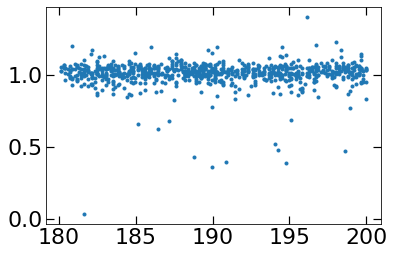

In [74]:
bin_num = 9
plt.plot(data[data['bin'] == bin_num][0], data[data['bin'] == bin_num][1], '.')

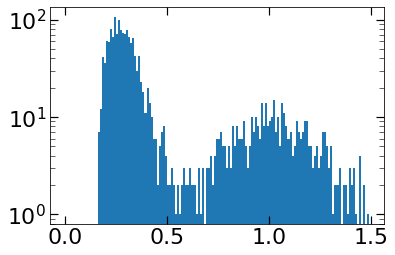

In [75]:
binspace = 0.01
hist_bins = np.arange(0, 1.5, binspace)
bin_num = 0
n, bins = np.histogram(data[data['bin'] == bin_num][1], bins=hist_bins)
fig = plt.hist(data[data['bin'] == bin_num][1], bins=hist_bins, log=True)
#print (n)

#plt.xlim(0.7,1.4)

In [7]:
#define a Gaussian 
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [8]:
#do a fit
from scipy.optimize import curve_fit
from scipy.stats import moment

bin_num = 3

def fit_data(data, bounds):
    """
    bounds is an array of form [(x_min, x_max), (ymin, ymax)]
    data is a pandas data frame with two columns, data[0] is the column that is cut on
    and data[1] is the column that is histogrammed and fit"""
    x_min = min(bounds[0])
    x_max = max(bounds[0])
    yield_min = min(bounds[1])
    yield_max = max(bounds[1])

    # sanitize fitdata
    fitdata = data[(data[0] >= x_min) & (data[0] <= x_max)][1]
    fitdata = fitdata[(fitdata > yield_min) & (fitdata < yield_max)]

    n, bin_edges = np.histogram(fitdata, 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ymean = np.mean(fitdata)
    ysig = np.mean(fitdata)
    ymax = np.max(fitdata)

    popt, pcov = curve_fit(gaus,bin_centers,n,p0=[np.max(n), ymean, ysig])
   
    return popt, pcov, bounds[0]

popt, pcov, xbound = fit_data(data, [(0, 20), (0.7, 1.2)])

print(popt)
print(pcov)
print(xbound)

# make the bins
bin_edges = np.arange(0, 220, step=20)

xbounds = []
for low, high in zip(bin_edges, bin_edges[1:]):
    xbounds.append((low, high))

print (xbounds)

par_arr = []
for bound in xbounds:
    popt, pcov, x = fit_data(data, [bound, (0.7, 1.4)])
    par_arr.append(popt)
    

"""
# probably a bad idea to use skewedness!
# higher moments depend a *lot* on sample size
ymean = popt[1]
ysig = abs(popt[2])
c = 3
momentdata = data[data['bin'] == bin_num][1]
momentdata = momentdata[(momentdata > ymean - c*ysig) & (momentdata < ymean + c*ysig)]
print ("moment:", moment(momentdata, moment=1), moment(momentdata, moment=2), moment(momentdata, moment=3)/ysig**3, moment(momentdata, moment=4))
"""

[4.57533453 1.013142   0.2034072 ]
[[ 0.11456473 -0.00149449 -0.00686208]
 [-0.00149449  0.00056586  0.00038831]
 [-0.00686208  0.00038831  0.0010595 ]]
(0, 20)
[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 120), (120, 140), (140, 160), (160, 180), (180, 200)]


'\n# probably a bad idea to use skewedness!\n# higher moments depend a *lot* on sample size\nymean = popt[1]\nysig = abs(popt[2])\nc = 3\nmomentdata = data[data[\'bin\'] == bin_num][1]\nmomentdata = momentdata[(momentdata > ymean - c*ysig) & (momentdata < ymean + c*ysig)]\nprint ("moment:", moment(momentdata, moment=1), moment(momentdata, moment=2), moment(momentdata, moment=3)/ysig**3, moment(momentdata, moment=4))\n'

(40, 60)


Text(0.5,0,'Recoil Energy (keV)')

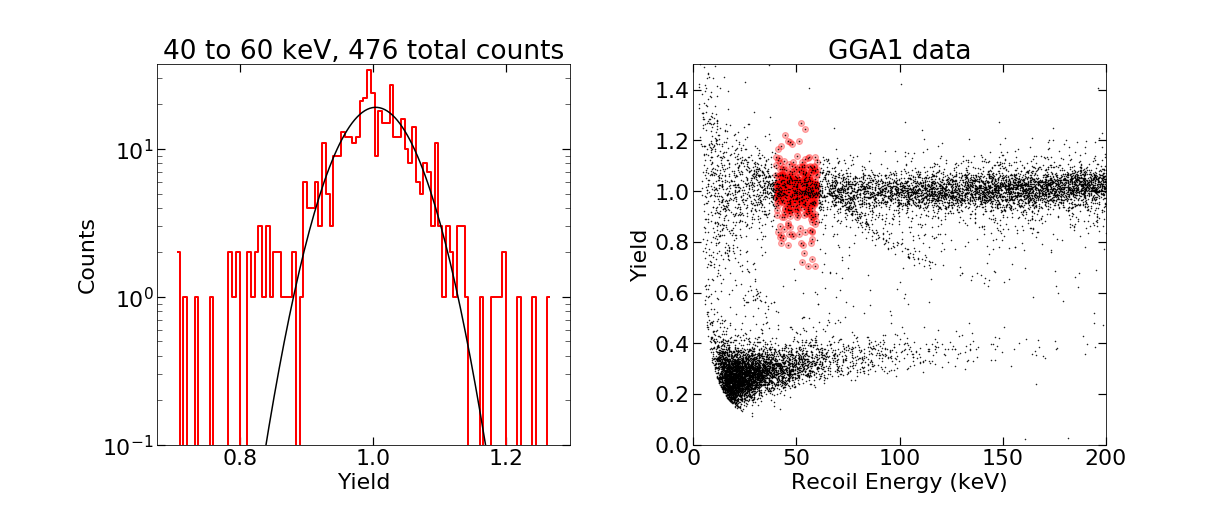

In [76]:
bin_idx = 2
popt = par_arr[bin_idx]
(x_min, x_max) = xbounds[bin_idx]
yield_min = 0.7
yield_max = 1.4
print(xbounds[bin_idx])

fitmask = (data[0] >= x_min) & (data[0] <= x_max) & (data[1] > yield_min) & (data[1] < yield_max)
fitdata = data[fitmask][1]
n, bin_edges = np.histogram(fitdata, 100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

X = np.linspace(min(fitdata), max(fitdata),150)
fit = gaus(X,*popt)

ymin = 0.1
ymax = np.max(n) * 1.1
fig,axes = plt.subplots(1,2,figsize=(17.0,7.0), constrained_layout=True)
plt.subplots_adjust(wspace = 0.3)
ax1 = axes[0]
ax1.set_yscale('log')
ax1.set_ylim(ymin, ymax)
step, = ax1.step(bin_centers, n, where='mid',color='r', linestyle='-', label='Yield', linewidth=2)
ax1.set_ylabel("Counts")
ax1.set_xlabel("Yield")
ax1.set_title("{:d} to {:d} keV, {:d} total counts".format(x_min, x_max, len(fitdata)))
ax1.plot(X,fit,'k-',label='fit')

ax2 = axes[1]
ax2.plot(data[fitmask][0], data[fitmask][1],'ro', alpha=0.3)
ax2.plot(data[0], data[1], 'ko', alpha=1, markersize=0.5)

ax2.set_xlim(0, 200)
ax2.set_ylim(0, 1.5)
ax2.set_title("GGA1 data")
ax2.set_ylabel("Yield")
ax2.set_xlabel("Recoil Energy (keV)")